# ⏰ 시계열 데이터 분석 실습

> **시계열 데이터**: 시간의 흐름에 따라 관측되어 수집된 통계량으로 시간의 영향을 받는 데이터

**학습 목표:**
1. 시계열 데이터의 기본 개념과 특징 이해
2. 시계열 데이터 전처리 방법 학습 (결측치/이상치, 요소분해)
3. 정상성 개념 및 검정 방법 이해
4. 정상성 확보를 위한 변환 기법 실습

## 0. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import platform

# 운영체제에 따라 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')  # Windows 전용 폰트
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')  # macOS 전용 폰트
else:
    plt.rc('font', family='NanumGothic')  # 리눅스 또는 기타 환경
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 시계열 분석 라이브러리
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


---

# Part 1. 시계열 데이터 기본 개념

## 1.1 시계열 데이터의 특징

- **시간의존성 (Temporal Dependence)**: 데이터는 시간에 따라 변화한다
- **자기상관성 (Autocorrelation)**: 이전 시점의 값이 이후 시점의 값에 영향을 미친다
- **계절성 (Seasonality) & 추세 (Trend)**: 시간에 따라 장기적으로 증가/감소하는 추세 + 일정 주기로 반복되는 패턴

## 1.2 Sunspots 데이터 소개

### Sunspots Yearly Dataset (태양 흑점 연간 관측 데이터)

- 태양의 표면에서 관측되는 "흑점(Sunspots)"의 개수를 1년 단위로 기록한 데이터
- **관측 시작**: 1700년
- **종료**: 2008년
- **빈도**: Annual (연간)
- **값**: 그 해에 관측된 태양 흑점의 평균 개수
- **특징**: 태양 흑점은 약 **11년 주기**로 증가·감소하는 경향

## 1.3 데이터 로드 및 기본 시각화

pd.to_datetime() 함수 사용법:
- 기본 형식: pd.to_datetime(데이터, format='날짜형식')
- format 파라미터:  
· '%Y': 4자리 연도 (예: 2023)
· '%y': 2자리 연도 (예: 23)
· '%m': 월 (01-12)
· '%d': 일 (01-31)
· '%H': 시간 (00-23)
· '%M': 분 (00-59)

In [3]:
# Sunspots 연간 데이터 불러오기
data = sm.datasets.sunspots.load_pandas().data

# 'YEAR' → datetime 변환
# pd.to_datetime(데이터, format='날짜형식'), 4자리 연도 방식을 사용해주세요!
data['YEAR'] = pd.to_datetime(data['YEAR'], format='%Y')

# 시계열 분석에서는 날짜를 인덱스로 설정해야 함
# inplace=True는 원본 데이터를 직접 수정
data.set_index('YEAR', inplace=True)

print(f"데이터 shape: {data.shape}")
print(f"\n데이터 기간: {data.index[0].year} ~ {data.index[-1].year}")

print(f"\n기본 통계:")
print(data['SUNACTIVITY'].describe())

데이터 shape: (309, 1)

데이터 기간: 1700 ~ 2008

기본 통계:
count    309.000000
mean      49.752104
std       40.452595
min        0.000000
25%       16.000000
50%       40.000000
75%       69.800000
max      190.200000
Name: SUNACTIVITY, dtype: float64


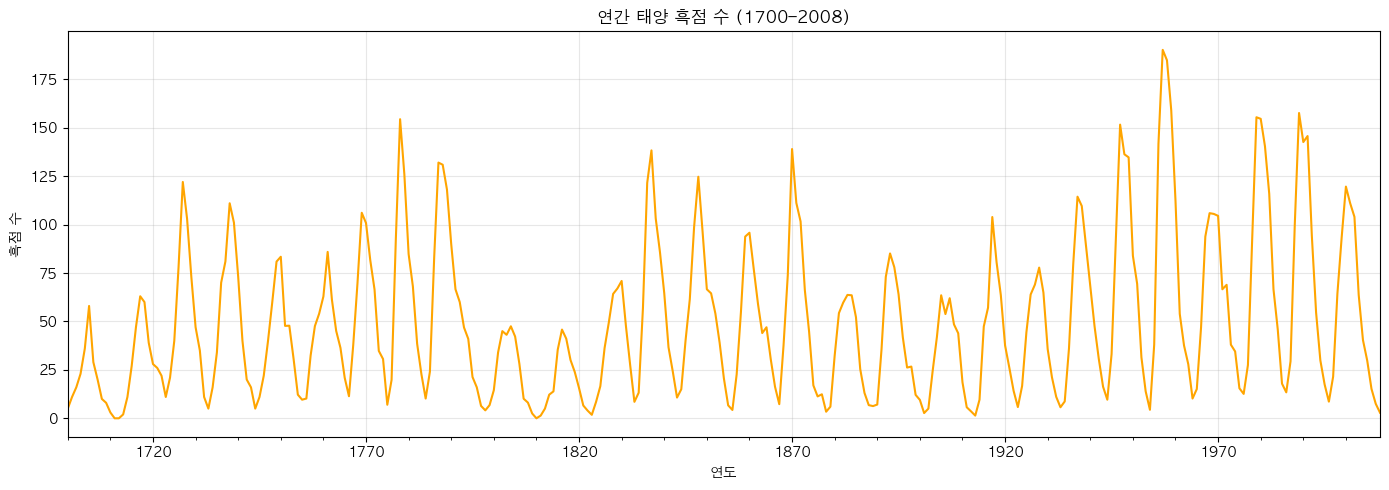

In [4]:
# 시각화
plt.figure(figsize=(14, 5))
data['SUNACTIVITY'].plot(title='연간 태양 흑점 수 (1700–2008)', color='orange', linewidth=1.5)
plt.ylabel('흑점 수')
plt.xlabel('연도')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 관찰 포인트

1. **주기성**: 약 11년마다 흑점 수가 증가와 감소를 반복 (태양 활동 주기)
2. **추세**: 전반적으로 1700년대보다 1900년대 후반의 평균 흑점 수가 높음
3. **변동성**: Peak 값의 크기가 주기마다 다름 (최대 190개, 최소 0개 근처)

---

# Part 2. 시계열 요소 분해 (Decomposition)

> **요소분해**: 주어진 시계열 데이터를 개별 성분(추세성, 계절성, 순환성, 불규칙성)으로 분해하는 과정

태양 흑점 수는 약 **11년 주기**가 있기 때문에 요소 분해 시 `period=11`을 사용합니다.

**seasonal_decompose() 함수 사용법:**
- `model='additive'`: 가법 모형 (데이터 = 추세 + 계절성 + 잔차)
- `model='multiplicative'`: 승법 모형 (데이터 = 추세 × 계절성 × 잔차)
- `period`: 계절성 주기

**언제 어떤 모형을 사용할까?**
- 가법 모형: 계절성 변동폭이 일정할 때
- 승법 모형: 추세가 증가하면 계절성 변동폭도 커질 때

## 2.1 가법 모형 (Additive Model)

가법 모형은 시계열을 다음과 같이 분해합니다:

$$Y_t = T_t + S_t + E_t$$

- $T_t$: 추세 (Trend)
- $S_t$: 계절성 (Seasonal)
- $E_t$: 잔차 (Residual/Error)

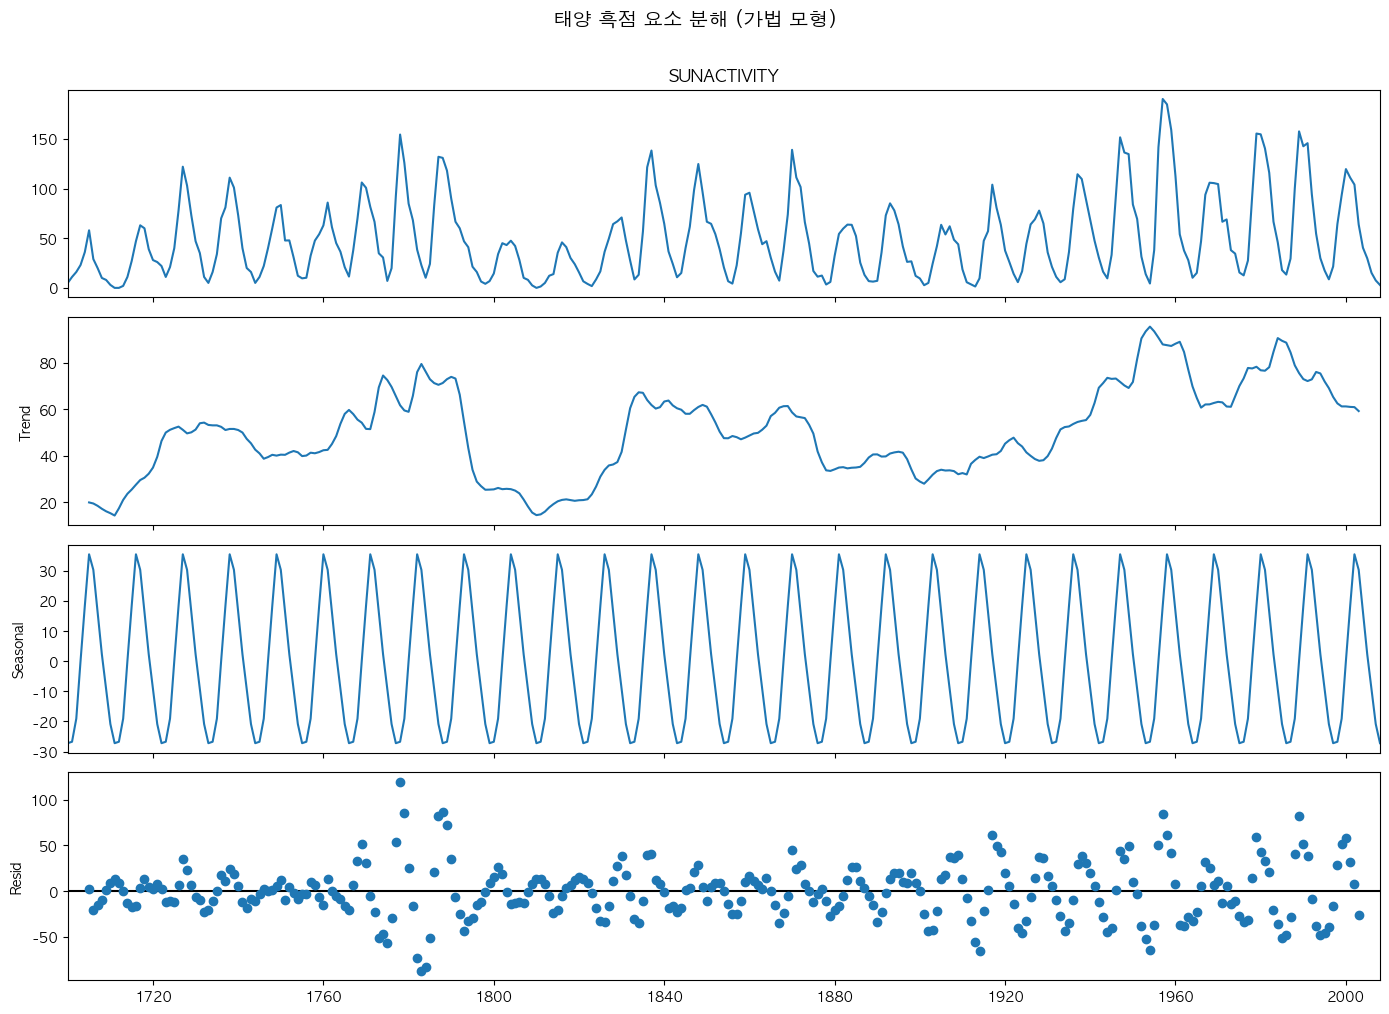

In [5]:
# 가법 모형으로 요소 분해
decomp_add = seasonal_decompose(
    data['SUNACTIVITY'],
    model='additive', # 어떤 모형일까요
    period=11 # 주기가 뭐죠
)

# 시각화
fig_add = decomp_add.plot()
fig_add.set_size_inches(14, 10)
plt.suptitle("태양 흑점 요소 분해 (가법 모형)", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

## 2.2 승법 모형 (Multiplicative Model)
### 2.2.1 개념
승법 모형은 시계열을 다음과 같이 분해합니다:

$$Y_t = T_t \times S_t \times E_t$$

**주의**: 승법 모형은 시계열 값이 **0 또는 음수**면 적용할 수 없습니다.

In [6]:
try:
    decomp_mul_raw = seasonal_decompose(
        data['SUNACTIVITY'],
        model='multiplicative', # 어떤 모형일까요
        period=11 # 주기가 뭐죠
    )
    print("✅ 승법 모형 적용 성공!")
except Exception as e:
    print("❌ 오류 발생!")
    print(f"오류 타입: {type(e).__name__}")
    print(f"오류 메시지: {str(e)}")

❌ 오류 발생!
오류 타입: ValueError
오류 메시지: Multiplicative seasonality is not appropriate for zero and negative values


### 2.2.2 0 또는 음수 값 확인

오류 메시지: Multiplicative seasonality is not appropriate for zero and negative values

승법 모형은 $Y_t = T_t \times S_t \times E_t$ 형태로 분해하므로, **0이나 음수가 있으면 수학적으로 불가능**합니다.

데이터에 0 또는 음수 값이 있는지 확인해보겠습니다.

전체 데이터 개수: 309개
0 이하 값 개수: 3개
0 이하 값 비율: 0.97%

0 이하 값이 있는 연도 (처음 10개):
            SUNACTIVITY
YEAR                   
1711-01-01          0.0
1712-01-01          0.0
1810-01-01          0.0


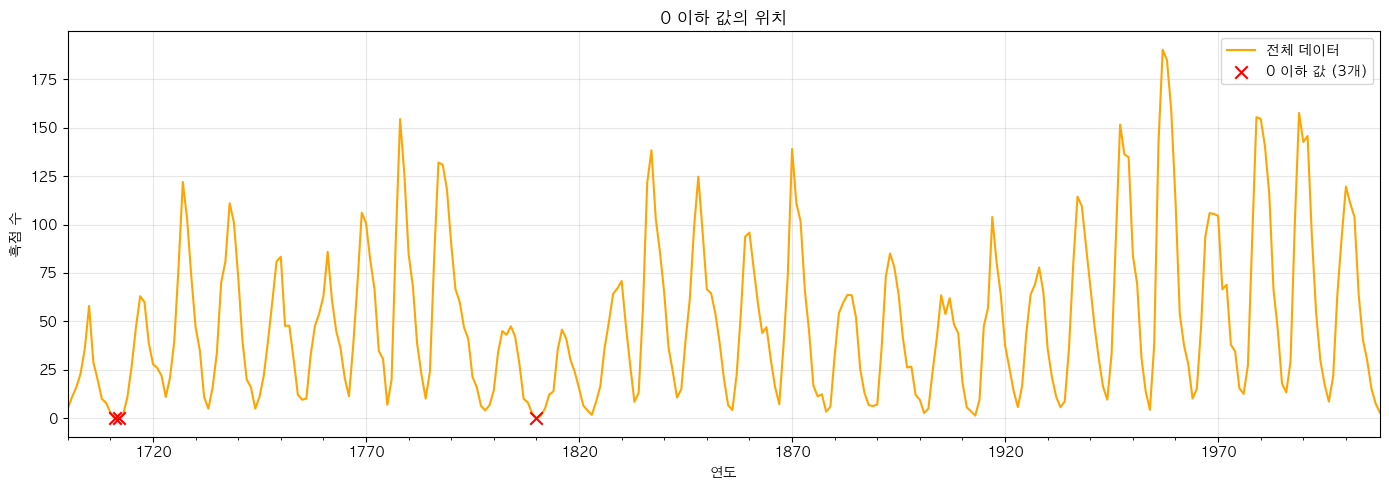

In [7]:
# 0 또는 음수 값 확인
zero_or_negative = data[data['SUNACTIVITY'] <= 0]

print(f"전체 데이터 개수: {len(data)}개")
print(f"0 이하 값 개수: {len(zero_or_negative)}개")
print(f"0 이하 값 비율: {len(zero_or_negative)/len(data)*100:.2f}%")

if len(zero_or_negative) > 0:
    print(f"\n0 이하 값이 있는 연도 (처음 10개):")
    print(zero_or_negative.head(10))
    
    # 시각화
    plt.figure(figsize=(14, 5))
    data['SUNACTIVITY'].plot(color='orange', linewidth=1.5, label='전체 데이터')
    plt.scatter(zero_or_negative.index, zero_or_negative['SUNACTIVITY'], 
                color='red', s=80, zorder=5, label=f'0 이하 값 ({len(zero_or_negative)}개)', marker='x')
    plt.ylabel('흑점 수')
    plt.xlabel('연도')
    plt.title('0 이하 값의 위치')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 2.2.3 해결 방법: 양수 값만 필터링

그래프를 확인해보시면, 0 이하 값이 존재함을 알 수 있습니다.

**결론:** 승법 모형을 적용하려면 **0보다 큰 값만 선택**해야 합니다.

이제 0보다 큰 값만 필터링하여 승법 모형을 적용하겠습니다.

In [8]:
# 0보다 큰 값만 필터링
data_pos = data[data['SUNACTIVITY'] > 0].copy()

print(f"원본 데이터 개수: {len(data)}개")
print(f"양수 데이터 개수: {len(data_pos)}개")
print(f"제거된 0 값 개수: {len(data) - len(data_pos)}개")

원본 데이터 개수: 309개
양수 데이터 개수: 306개
제거된 0 값 개수: 3개


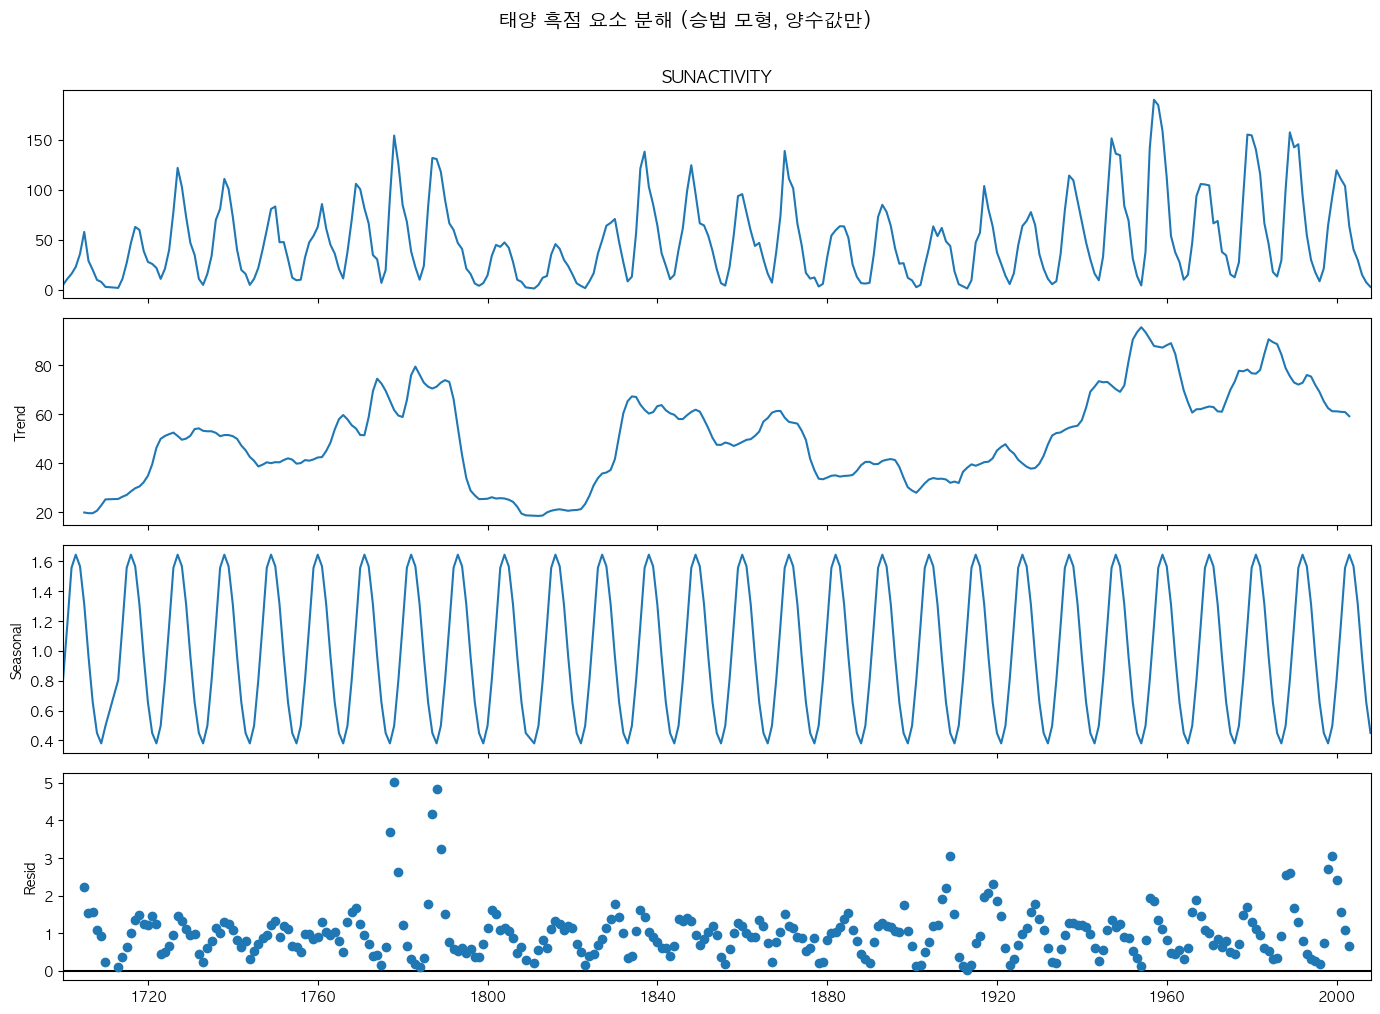

In [9]:
# 승법 모형으로 요소 분해
# 힌트: 시계열 분해 함수
decomp_mul = seasonal_decompose(
    data_pos['SUNACTIVITY'],
    # 힌트: 승법 모형 (multiplicative)
    model='multiplicative',
    # 힌트: 주기
    period=11
)

# 시각화
fig_mul = decomp_mul.plot()
fig_mul.set_size_inches(14, 10)
plt.suptitle("태양 흑점 요소 분해 (승법 모형, 양수값만)", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

## 참고) STL vs Seasonal Decompose  
요소분해 하는 방법으로 seasonal decompose 말고 STL도 있었죠?   

| 구분 | STL | Seasonal Decompose |
|------|------|---------------------|
| 요소 분해 방식 | LOESS(국소 회귀) | 이동평균 기반 고전적 분해 |
| 계절성 처리 | **시간에 따라 변하는 계절성 반영** | **고정된 계절성만 반영** |
| 이상치 영향 | 적게 받음 (robust 옵션 가능) | 많이 받음 |
| 데이터 손실 | 없음 | 있음 (이동평균 계산 구간만큼 앞뒤 데이터 손실) |

**STL**은 LOESS 기반으로 계절성과 추세를 국소적으로 반복 추정하기 때문에   
계절성의 진폭이나 형태가 시간이 흐르면서 변하는 실제 데이터 환경을 자연스럽게 반영할 수 있어요.   
반면 **Seasonal Decompose**는 고정된 계절 패턴을 전제로 하므로, 계절성이 변하거나 이상치가 포함된 데이터에서는 분해 성능이 떨어질 수 있습니다!

태양 흑점 데이터를 STL로도 요소분해 해보고 seasonal decompose랑 비교해보도록 하겠습니다.

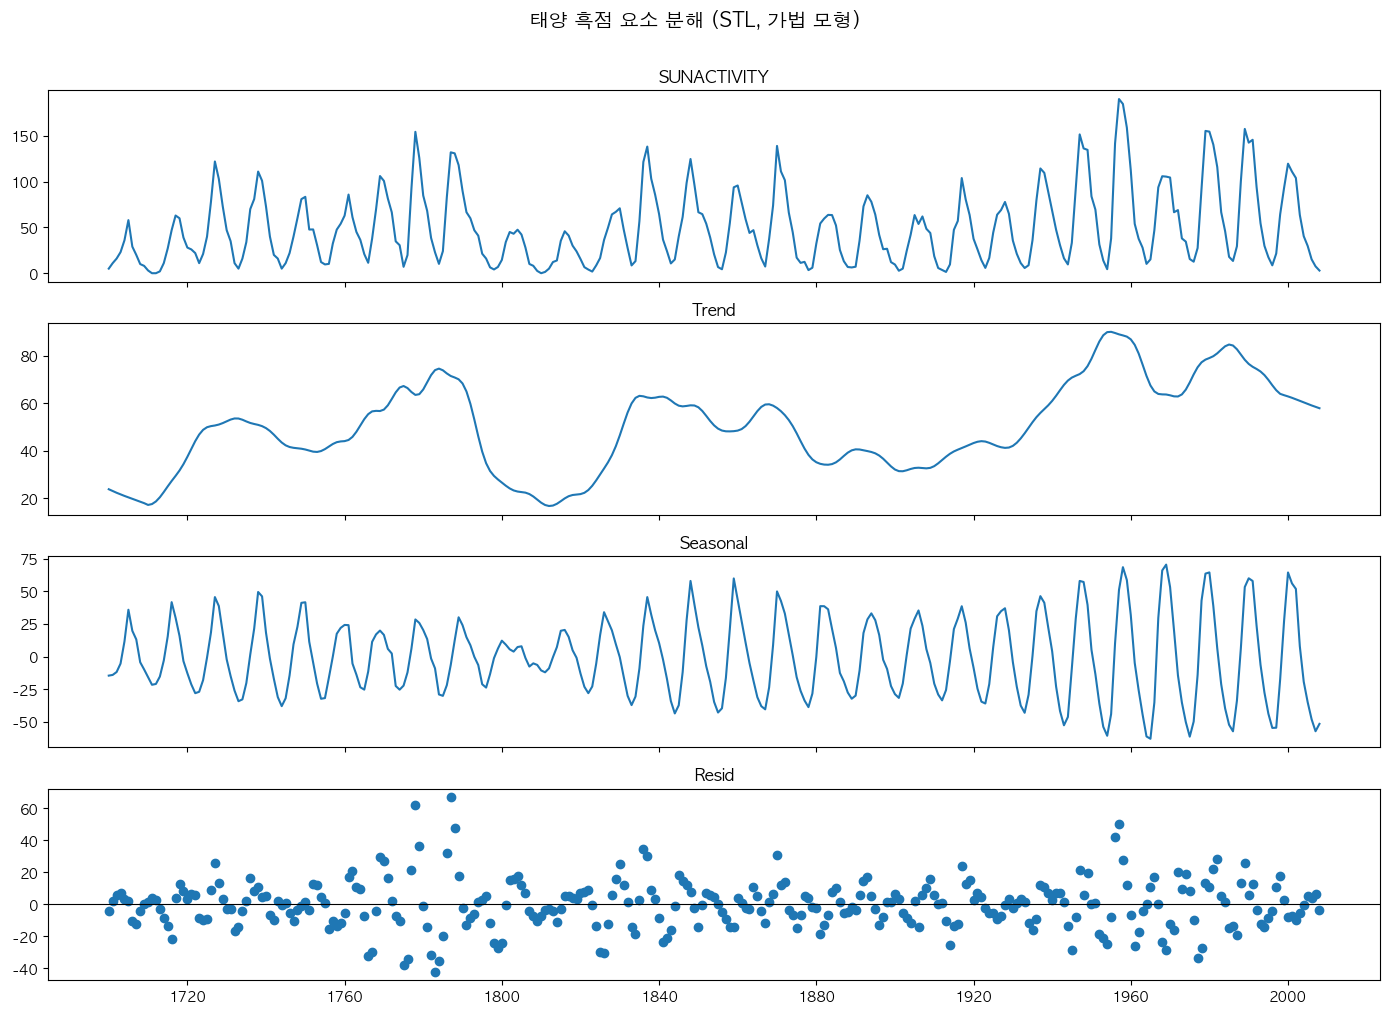

In [10]:
from statsmodels.tsa.seasonal import STL

# STL 가법 모형으로 요소 분해
stl = STL(
    data['SUNACTIVITY'],
    period=11   # 태양 흑점 주기(대략 11년 주기)
)
result = stl.fit()

# 시각화
# STL은 내장 plot에 figsize 옵션이 없어서, figure와 axes를 따로 만들어 크기를 조절해야 합니다
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(result.observed)
axes[0].set_title("SUNACTIVITY")

axes[1].plot(result.trend)
axes[1].set_title("Trend")

axes[2].plot(result.seasonal)
axes[2].set_title("Seasonal")

axes[3].plot(result.resid, marker='o', linestyle='none')
axes[3].axhline(0, color='black', linewidth=0.8)
axes[3].set_title("Resid")

fig.suptitle("태양 흑점 요소 분해 (STL, 가법 모형)", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

**Seasonal Decompose 가법모형 결과 이미지**

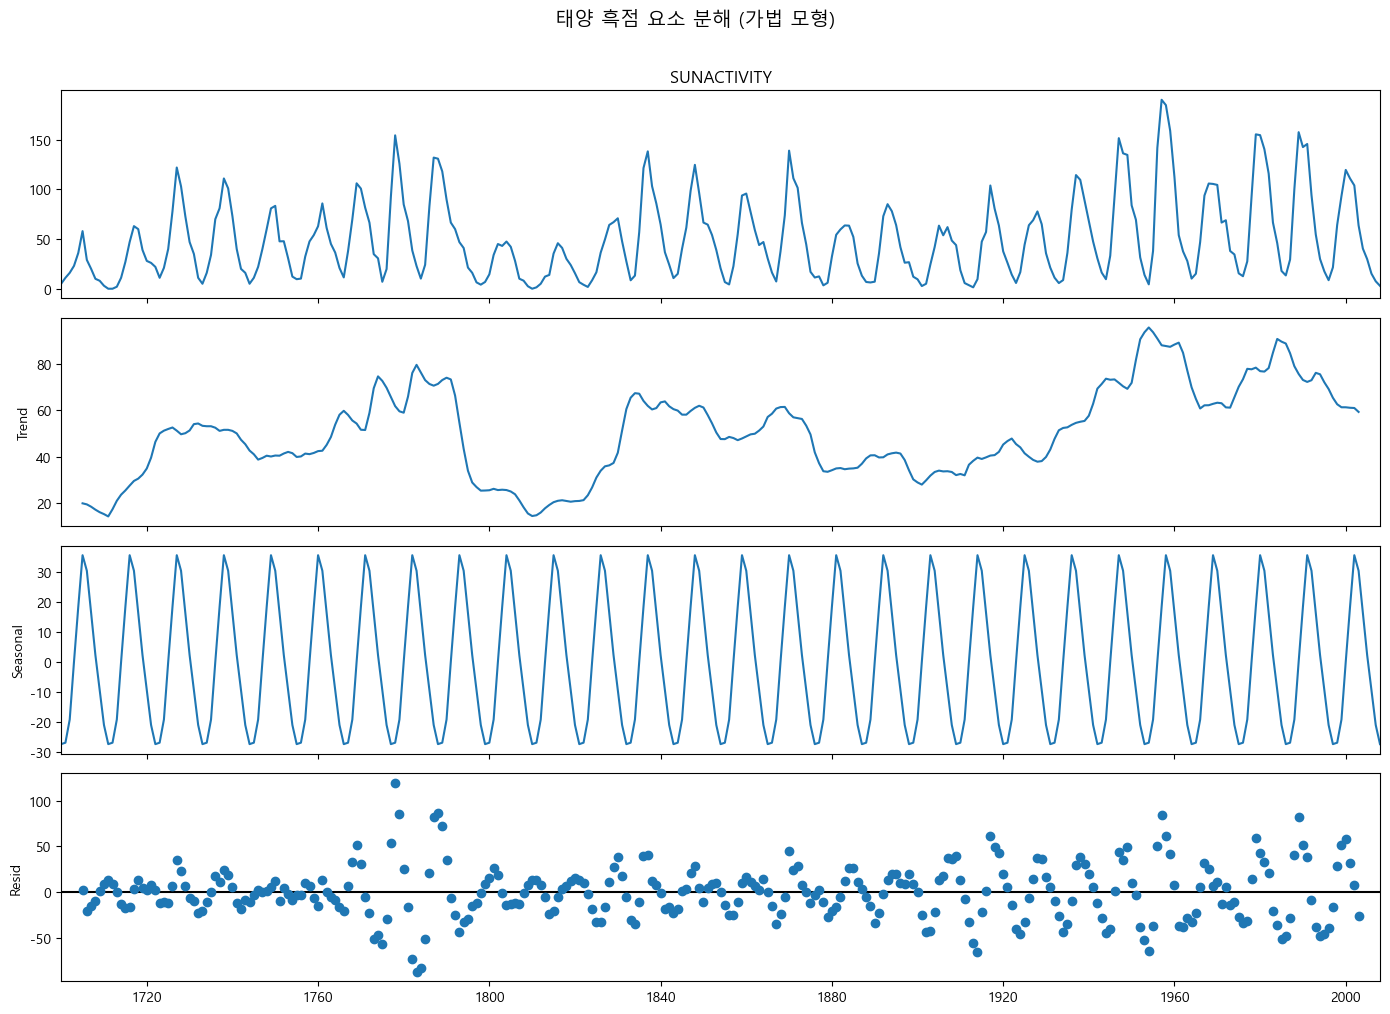

둘을 비교해보면 **seasonal decompose**의 trend에 자잘한 진동이 남아있는 게 보이죠?    
완벽하게 분리하지 못한 계절성 부분이 trend에 남아 있는 것 같습니다.  
**STL** 요소 분해 결과를 보면 계절성이 변하는 게 보이시나요? 반면에 **seasonal decompose**쪽은 일정해보입니다.    
태양 흑점 데이터의 계절성의 모양이 일정하지 않기 때문에 변동하는 계절성을 반영하는 **STL** 방법으로 요소 분해한 결과가 더 잘 나왔다고 볼 수 있습니다.  

## 2.3 요소 분해 결과 해석 (가법 모형 기준)

| 구성요소 | 특징 | 해석 |
|---------|-------|--------|
| **원본 시계열 (SUNACTIVITY)** | - 약 11년 주기 반복<br>- Peak: 150~200<br>- Valley: 0 근처 | → 태양 흑점의 **강한 주기성 + 장기적 변동**이 동시에 존재 |
| **추세 (Trend)** | - 1700년대 초반: 낮음<br>- 1780~1820: 급락 (달튼 최소기)<br>- 1870~1960: 상승 추세<br>- 1960~2000: 높은 수준 유지 | → **장기적 증가 경향**, 역사적 최소·최대기 반영 |
| **계절성 (Seasonal)** | - 약 11년 주기 반복<br> - 모양은 대체로 규칙적 (사인파 비슷)<br> - 진폭은 시기별로 다를 수 있음 (STL에서 더 잘 드러남) | → 흑점의 **고유한 11년 주기성**을 보여줌 |
| **잔차 (Residual)** | - 평균 0 근처에서 흩어짐<br>- 1780~1830 변동 폭 큼<br>- 구조적 패턴 없음 | → **추세·계절성으로 설명되지 않는 불규칙 변동(노이즈)** |

**종합 해석:**

태양 흑점 데이터는 뚜렷한 **11년 주기의 계절성**, **장기간의 추세 변화**, 그리고 예측하기 어려운 **불규칙 변동(잔차)** 로 구성됩니다.

---

# Part 3. 전처리 - 결측치 처리

## 3.1 결측치 확인

In [11]:
# 결측치 확인
print("결측치 개수:")
print(data.isna().sum())

print(f"\n결측치 비율: {data['SUNACTIVITY'].isna().sum() / len(data) * 100:.2f}%")

결측치 개수:
SUNACTIVITY    0
dtype: int64

결측치 비율: 0.00%


**결과:** 실제 데이터에는 결측치가 없습니다.

하지만 실무에서는 결측치가 발생할 수 있으므로, **인위적으로 결측치를 생성하여 보간 방법을 실습**해보겠습니다.

## 3.2 결측치 생성 및 보간 실습

### 3.2.1 인위적 결측치 생성

실습을 위해 **1800-1900년 구간(100년)에 35개의 결측치**를 생성합니다.

**이 구간을 선택한 이유:**
- 태양 흑점의 11년 주기가 약 9번 반복되어 보간 방법의 패턴 추적 능력을 평가하기 용이
- 충분한 결측치(~35%)로 각 보간 방법의 특징을 극대화
- 시각화 시 비교가 명확함

In [12]:
# 1. 원본 데이터 복사
data_with_missing = data['SUNACTIVITY'].copy()

# 2. 1800-1900년 구간에서 결측치 생성
# seed 함수를 통해 재현 가능하도록 설정할 수 있습니다
np.random.seed(42)  # 재현 가능하도록

# 1800-1900년 구간의 인덱스 추출
range_data = data.loc['1800':'1900']
n_missing = 35  # 해당 구간에 35개의 결측치 생성

missing_indices = np.random.choice(
    range_data.index,
    size=n_missing,
    replace=False
)

# 결측치로 변환
data_with_missing.loc[missing_indices] = np.nan

print(f"생성된 결측치 개수: {n_missing}개")
print(f"결측치 생성 구간: 1800-1900년")
print(f"해당 구간 전체 데이터: {len(range_data)}개")
print(f"해당 구간 결측치 비율: {n_missing/len(range_data)*100:.1f}%")
print(f"\n결측치가 생성된 연도 (처음 10개):")
print(sorted(missing_indices)[:10])

생성된 결측치 개수: 35개
결측치 생성 구간: 1800-1900년
해당 구간 전체 데이터: 101개
해당 구간 결측치 비율: 34.7%

결측치가 생성된 연도 (처음 10개):
[np.datetime64('1800-01-01T00:00:00.000000000'), np.datetime64('1804-01-01T00:00:00.000000000'), np.datetime64('1809-01-01T00:00:00.000000000'), np.datetime64('1810-01-01T00:00:00.000000000'), np.datetime64('1811-01-01T00:00:00.000000000'), np.datetime64('1812-01-01T00:00:00.000000000'), np.datetime64('1815-01-01T00:00:00.000000000'), np.datetime64('1818-01-01T00:00:00.000000000'), np.datetime64('1822-01-01T00:00:00.000000000'), np.datetime64('1826-01-01T00:00:00.000000000')]


### 3.2.2 여러 보간 방법 비교

다양한 보간 방법을 적용하여 결측치를 채워보겠습니다:

1. **Linear Interpolation** (선형 보간): 전후 값의 선형 관계로 채움
2. **Spline Interpolation** (스플라인 보간): 부드러운 곡선으로 채움
3. **Forward Fill**: 이전 값으로 채움
4. **Backward Fill**: 다음 값으로 채움

### 3.2.2.1 Linear Interpolation (선형 보간)

**개념:**
- 결측치 전후의 두 값을 직선으로 연결하여 채우는 방법
- 가장 단순하고 빠른 보간 방법

**장점:**
- 계산이 간단하고 빠름
- 짧은 구간의 결측치에 효과적

**단점:**
- 급격한 변화나 곡선 패턴을 제대로 반영하지 못함
- 결측치가 긴 구간에서는 부정확할 수 있음

**사용 사례:**
- 단기간의 결측치
- 선형적으로 변하는 데이터

**interpolate() 메서드:**
- `method='linear'`: 선형 보간 (가장 기본적인 방법)
- 앞 값과 뒤 값을 직선으로 연결하여 중간값 계산

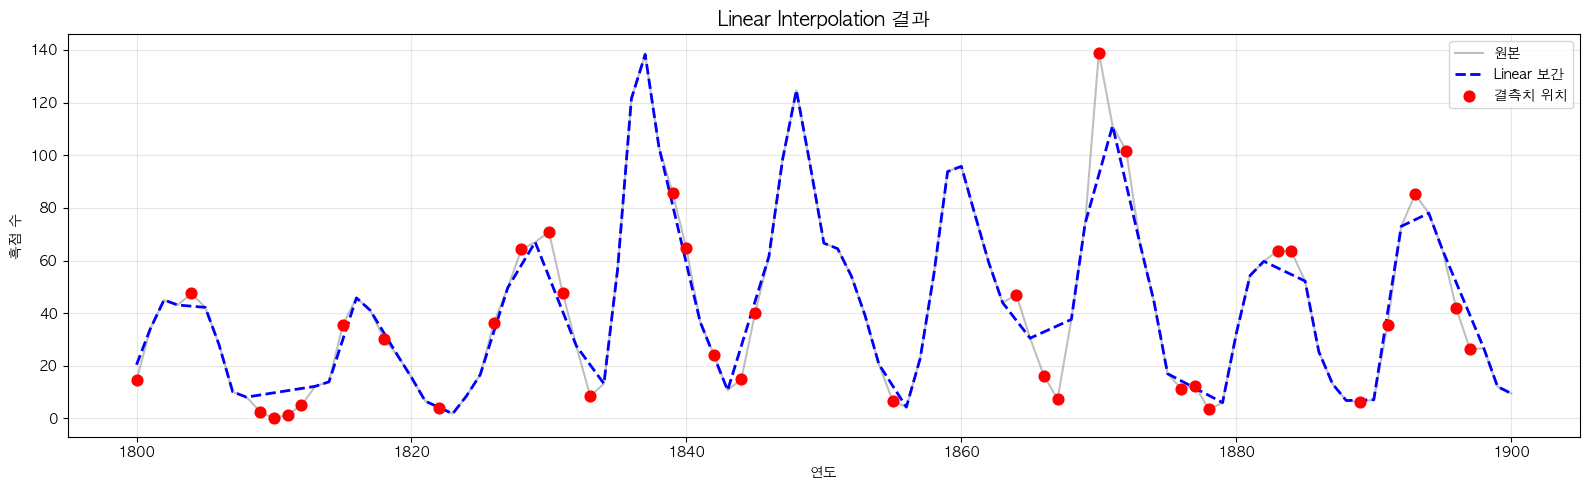

✅ Linear 보간 완료
   결측치: 0개


In [13]:
# Linear 보간 적용
# 힌트: 보간 메서드, method='linear'
data_linear = data_with_missing.interpolate(method='linear')

# 시각화
plt.figure(figsize=(16, 5))

# 해당 구간의 결측치만 필터링
missing_in_range = [idx for idx in missing_indices if '1800-01-01' <= str(idx) <= '1900-01-01']

# 원본 데이터 (회색)
plt.plot(data['SUNACTIVITY'].loc['1800-01-01':'1900-01-01'], 
         label='원본', color='gray', linewidth=1.5, alpha=0.5)

# Linear 보간 결과 (파란색)
plt.plot(data_linear.loc['1800-01-01':'1900-01-01'], 
         label='Linear 보간', color='blue', linewidth=2, linestyle='--')

# 결측치 위치 (빨간 점)
if missing_in_range:
    plt.scatter(missing_in_range, data['SUNACTIVITY'].loc[missing_in_range], 
                color='red', s=60, zorder=5, label='결측치 위치')

plt.title('Linear Interpolation 결과', fontsize=14, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Linear 보간 완료")
print(f"   결측치: {data_linear.isna().sum()}개")

**관찰 결과:**
- 결측치가 직선으로 연결되어 있음
- 태양 흑점의 11년 주기 곡선을 제대로 따라가지 못하고 각진 형태
- 짧은 결측 구간에서는 비교적 자연스럽지만, 긴 구간에서는 부자연스러움

### 3.2.2.2 Spline Interpolation (스플라인 보간)

**개념:**
- 여러 점을 부드러운 곡선으로 연결하는 방법
- 3차 다항식(cubic spline)을 사용하여 매끄러운 곡선 생성

**장점:**
- 자연스러운 곡선으로 패턴을 잘 따라감
- 주기적 패턴이나 곡선 데이터에 효과적

**단점:**
- 계산량이 많음
- 긴 결측 구간에서 과적합(overfitting) 가능성

**사용 사례:**
- 부드러운 변화가 예상되는 데이터
- 주기적 패턴을 가진 시계열 데이터


**Spline 보간:**
- `method='spline'`: 스플라인 보간 (곡선 형태)
- `order`: 다항식 차수 (보통 3차 사용)
- Linear보다 부드럽고 자연스러운 곡선 생성

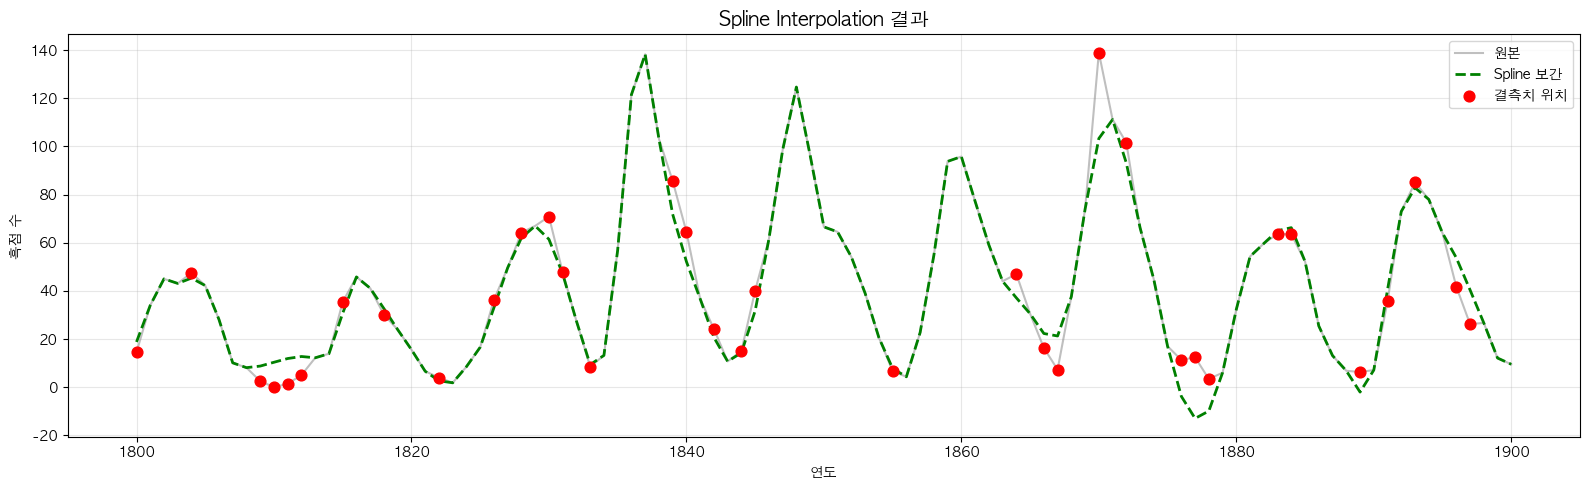

✅ Spline 보간 완료
   결측치: 0개


In [14]:
# Spline 보간 적용 (3차 스플라인)
# 힌트: 보간 메서드, method='spline', order=3
data_spline = data_with_missing.interpolate(method='spline', order=3)

# 시각화
plt.figure(figsize=(16, 5))

missing_in_range = [idx for idx in missing_indices if '1800-01-01' <= str(idx) <= '1900-01-01']

# 원본 데이터 (회색)
plt.plot(data['SUNACTIVITY'].loc['1800-01-01':'1900-01-01'], 
         label='원본', color='gray', linewidth=1.5, alpha=0.5)

# Spline 보간 결과 (초록색)
plt.plot(data_spline.loc['1800-01-01':'1900-01-01'], 
         label='Spline 보간', color='green', linewidth=2, linestyle='--')

# 결측치 위치 (빨간 점)
if missing_in_range:
    plt.scatter(missing_in_range, data['SUNACTIVITY'].loc[missing_in_range], 
                color='red', s=60, zorder=5, label='결측치 위치')

plt.title('Spline Interpolation 결과', fontsize=14, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Spline 보간 완료")
print(f"   결측치: {data_spline.isna().sum()}개")

**관찰 결과:**
- Linear보다 훨씬 부드러운 곡선으로 연결됨
- 태양 흑점의 주기적 패턴을 비교적 잘 따라감
- 원본 데이터의 곡선 특성을 가장 잘 보존하는 방법

### 3.2.2.3 Forward Fill (전방 채우기)

**개념:**
- 결측치를 이전 값으로 채우는 방법
- "마지막으로 관측된 값이 유지된다"고 가정

**장점:**
- 매우 간단하고 빠름
- 값이 급격히 변하지 않는 데이터에 적합

**단점:**
- 계단 형태(step function)로 부자연스러움
- 추세나 패턴을 전혀 고려하지 않음

**사용 사례:**
- 센서 오류로 인한 일시적 결측
- 상태가 유지되는 categorical 데이터

**fillna() 메서드:**
- `method='ffill'`: 이전 값으로 채우기 (forward fill)
- `method='bfill'`: 다음 값으로 채우기 (backward fill)
- 간단하지만 계단식 패턴이 나타날 수 있음

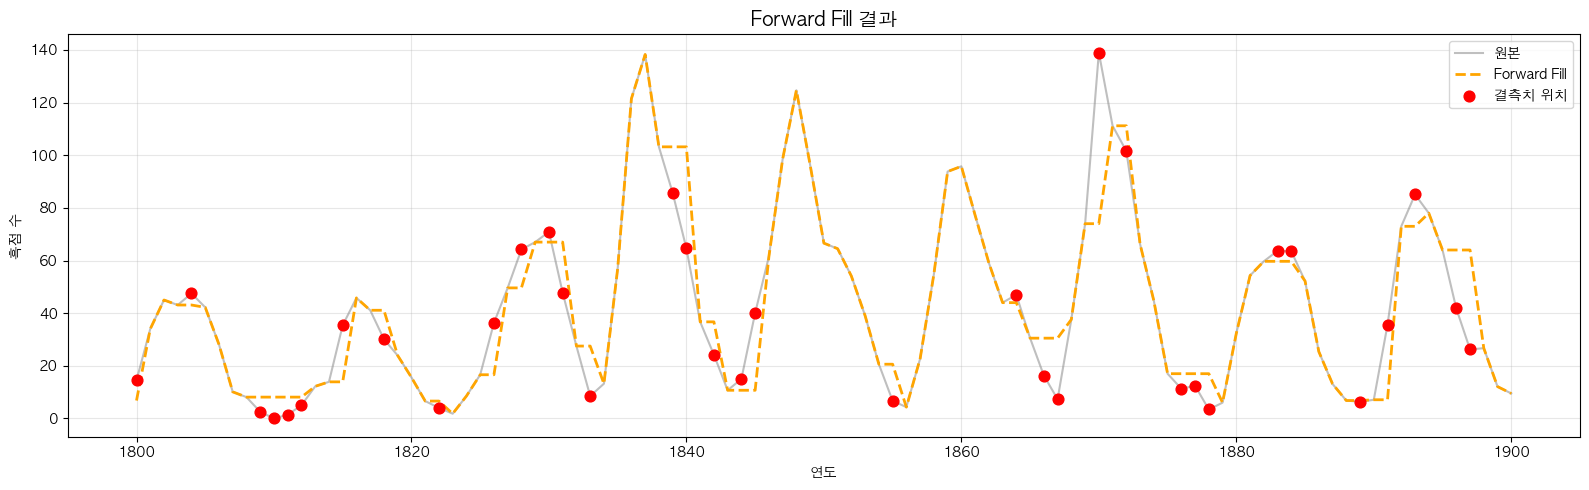

✅ Forward Fill 완료
   결측치: 0개


In [15]:
# Forward Fill 적용
# 힌트: 결측치 채우기, method='ffill'
data_ffill = data_with_missing.fillna(method='ffill')

# 시각화
plt.figure(figsize=(16, 5))

missing_in_range = [idx for idx in missing_indices if '1800-01-01' <= str(idx) <= '1900-01-01']

# 원본 데이터 (회색)
plt.plot(data['SUNACTIVITY'].loc['1800-01-01':'1900-01-01'], 
         label='원본', color='gray', linewidth=1.5, alpha=0.5)

# Forward Fill 결과 (주황색)
plt.plot(data_ffill.loc['1800-01-01':'1900-01-01'], 
         label='Forward Fill', color='orange', linewidth=2, linestyle='--')

# 결측치 위치 (빨간 점)
if missing_in_range:
    plt.scatter(missing_in_range, data['SUNACTIVITY'].loc[missing_in_range], 
                color='red', s=60, zorder=5, label='결측치 위치')

plt.title('Forward Fill 결과', fontsize=14, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Forward Fill 완료")
print(f"   결측치: {data_ffill.isna().sum()}개")

**관찰 결과:**
- 명확한 계단 형태가 보임
- 이전 값이 다음 결측치까지 그대로 유지됨
- 시계열의 추세나 패턴을 전혀 반영하지 못함
- 시각적으로 가장 부자연스러움

### 3.2.2.4 Backward Fill (후방 채우기)

**개념:**
- 결측치를 다음 값으로 채우는 방법
- "미래의 첫 관측값으로 역으로 채운다"고 가정

**장점:**
- 간단하고 빠름
- 미래 정보가 더 정확할 때 유용

**단점:**
- Forward Fill과 마찬가지로 계단 형태
- 추세나 패턴을 고려하지 않음

**사용 사례:**
- 사후 데이터 보정
- 미래 정보를 이용한 retrospective 분석

**Backward Fill:**
- `method='bfill'`: 다음 값으로 채우기 (backward fill)
- Forward Fill의 반대 방향

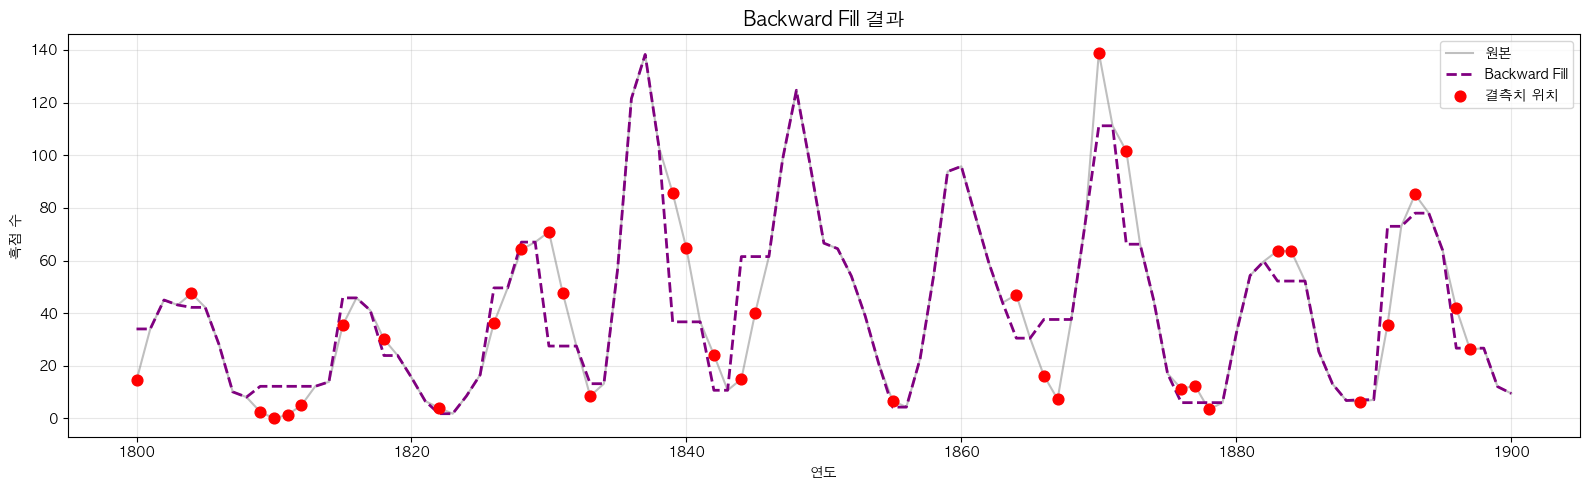

✅ Backward Fill 완료
   결측치: 0개


In [16]:
# Backward Fill 적용
# 힌트: 결측치 채우기, method='bfill'
data_bfill = data_with_missing.fillna(method='bfill')

# 시각화
plt.figure(figsize=(16, 5))

missing_in_range = [idx for idx in missing_indices if '1800-01-01' <= str(idx) <= '1900-01-01']

# 원본 데이터 (회색)
plt.plot(data['SUNACTIVITY'].loc['1800-01-01':'1900-01-01'], 
         label='원본', color='gray', linewidth=1.5, alpha=0.5)

# Backward Fill 결과 (보라색)
plt.plot(data_bfill.loc['1800-01-01':'1900-01-01'], 
         label='Backward Fill', color='purple', linewidth=2, linestyle='--')

# 결측치 위치 (빨간 점)
if missing_in_range:
    plt.scatter(missing_in_range, data['SUNACTIVITY'].loc[missing_in_range], 
                color='red', s=60, zorder=5, label='결측치 위치')

plt.title('Backward Fill 결과', fontsize=14, fontweight='bold')
plt.xlabel('연도')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ Backward Fill 완료")
print(f"   결측치: {data_bfill.isna().sum()}개")

**관찰 결과:**
- Forward Fill과 유사하게 계단 형태
- 다음 값이 이전 결측치까지 역으로 채워짐
- 시계열의 자연스러운 흐름을 반영하지 못함

### 3.2.3 성능 평가 (MAE, RMSE)

원본 데이터와 비교하여 각 보간 방법의 성능을 정량적으로 평가합니다.

**평가 지표:**
- MAE (Mean Absolute Error): 평균 절대 오차
- RMSE (Root Mean Squared Error): 평균 제곱근 오차
- 값이 낮을수록 원본 데이터와 유사함

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 결측치 위치의 원본 값
original_values = data['SUNACTIVITY'].loc[missing_indices]

# 각 보간 방법의 결측치 위치 값
linear_values = data_linear.loc[missing_indices]
spline_values = data_spline.loc[missing_indices]
ffill_values = data_ffill.loc[missing_indices]
bfill_values = data_bfill.loc[missing_indices]

# 성능 평가
results = []
for name, interpolated in [('Linear', linear_values),
                           ('Spline', spline_values),
                           ('Forward Fill', ffill_values),
                           ('Backward Fill', bfill_values)]:
    # 힌트: 평균 절대 오차 계산
    mae = mean_absolute_error(original_values, interpolated)
    # 힌트: 평균 제곱근 오차 계산 (제곱근 씌우기)
    rmse = np.sqrt(mean_squared_error(original_values, interpolated))
    results.append({'방법': name, 'MAE': mae, 'RMSE': rmse})

# 결과 DataFrame
# 힌트: MAE 기준 오름차순 정렬
results_df = pd.DataFrame(results).sort_values('MAE')


print("="*50)
print("보간 방법별 성능 비교 (MAE 기준 오름차순)")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)
print("\n💡 MAE와 RMSE가 낮을수록 원본 데이터와 유사합니다.")

보간 방법별 성능 비교 (MAE 기준 오름차순)
           방법       MAE      RMSE
       Spline  7.992958 10.797873
       Linear  8.712857 12.133540
 Forward Fill 14.602857 19.574349
Backward Fill 15.942857 20.801882

💡 MAE와 RMSE가 낮을수록 원본 데이터와 유사합니다.


### 3.2.4 결론 및 최적 방법 선택

**결과 분석:**

1. **Linear Interpolation**: 전후 값의 선형 관계로 자연스럽게 연결
2. **Spline Interpolation**: 부드러운 곡선으로 변동 패턴 반영
3. **Forward/Backward Fill**: 계단 형태로 급격한 변화 발생

**시계열 데이터 결측치 처리 권장사항:**

| 상황 | 추천 방법 | 이유 |
|------|-----------|------|
| **연속적 변화** | Linear/Spline | 시간에 따른 자연스러운 변화 반영 |
| **급격한 변동** | Spline | 곡선으로 부드럽게 처리 |
| **단기 결측** | Linear | 간단하면서도 효과적 |
| **센서 오류 등** | Forward/Backward Fill | 마지막 정상값 유지 |

**이 데이터에서는 Linear 또는 Spline 보간이 가장 적합합니다.**

---

# Part 4. 전처리 - 이상치 탐지

## 4.1 IQR 기반 이상치 탐지

**IQR (Interquartile Range):** 사분위수를 이용하여 이상치를 탐지합니다.
- Q1: 25% 백분위수
- Q3: 75% 백분위수
- IQR = Q3 - Q1
- 이상치 범위: [Q1 - 1.5×IQR, Q3 + 1.5×IQR] 벗어난 값

In [20]:
# IQR 기반 이상치 탐지
# 힌트: 25% 백분위수 계산
Q1 = data['SUNACTIVITY'].quantile(0.25)
# 힌트: 75% 백분위수 계산
Q3 = data['SUNACTIVITY'].quantile(0.75)
IQR = Q3 - Q1

# IQR 기준 설정
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# 이상치 탐지
# 힌트: 하한보다 작거나(|) 상한보다 큰 값 필터링
outliers_iqr = data[(data['SUNACTIVITY'] < lower) | (data['SUNACTIVITY'] > upper)]

print(f"Q1 (25%): {Q1:.2f}")
print(f"Q3 (75%): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"정상 범위: [{lower:.2f}, {upper:.2f}]")
print(f"\nIQR 기준 이상치 개수: {len(outliers_iqr)}개")
print(f"\n상위 5개 이상치:")
print(outliers_iqr.head())

Q1 (25%): 16.00
Q3 (75%): 69.80
IQR: 53.80
정상 범위: [-64.70, 150.50]

IQR 기준 이상치 개수: 8개

상위 5개 이상치:
            SUNACTIVITY
YEAR                   
1778-01-01        154.4
1947-01-01        151.6
1957-01-01        190.2
1958-01-01        184.8
1959-01-01        159.0


## 4.2 Z-score 기반 이상치 탐지

**Z-score**는 각 값이 평균으로부터 표준편차의 몇 배 떨어져 있는지를 나타냅니다.

$$Z = \frac{X - \mu}{\sigma}$$

일반적으로 **|Z| > 3**인 값을 이상치로 판단합니다.

In [21]:
# Z-score 계산
# 힌트: 원본 복사
data_outlier = data.copy()
# 힌트: (값 - 평균) / 표준편차
data_outlier['z_score'] = (data_outlier['SUNACTIVITY'] - data_outlier['SUNACTIVITY'].mean()) / data_outlier['SUNACTIVITY'].std()

# threshold 설정 (|z| > 3)
threshold = 3
# 힌트: 절댓값(np.abs), threshold보다 큰 값
outliers_z = data_outlier[np.abs(data_outlier['z_score']) > threshold]

print(f"평균: {data['SUNACTIVITY'].mean():.2f}")
print(f"표준편차: {data['SUNACTIVITY'].std():.2f}")
print(f"Threshold: |Z| > {threshold}")
print(f"\nZ-score 기준 이상치 개수: {len(outliers_z)}개")
print(f"\nZ-score 이상치:")
print(outliers_z[['SUNACTIVITY', 'z_score']])

평균: 49.75
표준편차: 40.45
Threshold: |Z| > 3

Z-score 기준 이상치 개수: 2개

Z-score 이상치:
            SUNACTIVITY   z_score
YEAR                             
1957-01-01        190.2  3.471913
1958-01-01        184.8  3.338424


## 4.3 이상치 처리 여부 판단

### ❓ 이상치로 판명되면 무조건 처리를 해야 할까?

**정답은? NO!**

태양 흑점 데이터는 태양 활동의 주기적 패턴 때문에 값의 변동 폭이 매우 큽니다.

- **IQR 기준**: 150~190대의 큰 값들이 이상치로 탐지
- **Z-score 기준**: 190대의 큰 값들이 이상치로 탐지

하지만 이는 천문학적으로 정상적인 **흑점 주기의 Peak**에 해당합니다.

### 💡 결론

**이 데이터에서는 이상치를 제거하지 않고 원본 그대로 사용하는 것이 바람직합니다.**

**교훈:** 데이터셋에 대한 도메인 지식을 바탕으로 적절히 판단하는 것이 중요합니다!

## 참고) 잔차에 IQR 적용해서 이상치 탐지
시계열 데이터 요소분해 후, 잔차에만 IQR 기준을 적용하여 이상치를 탐지하는 방법도 있다고 했었죠?  

**잔차에 IQR 적용하여 이상치를 찾는 방법의 장점**  
- 원본 데이터에는 정상적인 큰 변화(추세·계절성)가 포함되어 있어 false outlier가 발생하기 쉽다.  
- 잔차는 구조적 변동(추세·계절성)이 제거된 순수 비정상 변동만 남아 정확한 탐지가 가능하다.  
- 잔차의 분포는 더 안정적이어서 IQR과 같은 통계적 기준이 더 잘 작동한다.  

=> 따라서 **추세와 계절성이 뚜렷한 데이터**일수록 잔차에 IQR을 적용해 이상치를 탐지하는 것이 더 정확해집니다.

In [22]:
#stl 요소분해
stl = STL(data['SUNACTIVITY'], period=11)
result = stl.fit()

# 잔차(residual) 추출
resid = result.resid

#이상치 판단
outlier_resid = (resid < lower) | (resid > upper)

# 이상치만 모은 데이터프레임
outliers = data.loc[outlier_resid, ['SUNACTIVITY']].copy()
outliers['resid'] = resid[outlier_resid]

print("이상치 개수:", outlier_resid.sum())
display(outliers.head())

이상치 개수: 0


,SUNACTIVITY,resid
YEAR,,


### ❓이상치 개수가 0개인 이유
태양 흑점 데이터는 주기성이 규칙적이고, 원래 변동폭 자체가 매우 크기 때문에 '일반적인 통계적 이상치 기준(IQR·Z-score)'로 봤을 때 비정상적으로 튀는 값이 거의 없습니다.   
요소분해를 하면 '추세 + 계절성'이 대부분의 변동을 설명해버립니다.  
따라서 잔차에는 아주 작은 잡음만 남고, IQR 기준으로는 이상치가 거의 나타나지 않습니다.  

---

# Part 5. 정상성 검정

시계열 모델을 사용하기 위해서는 시계열 데이터의 **정상성(Stationarity)**을 확보해야 합니다.

**정상성이란?**
- 평균이 시간에 따라 일정
- 분산이 시간에 따라 일정
- 공분산이 시차에만 의존

## 5.1 ADF Test (Augmented Dickey-Fuller Test)

**귀무가설 (H0)**: 시계열 데이터는 **비정상** (단위근 존재)  
**대립가설 (H1)**: 시계열 데이터는 **정상**

- p-value < 0.05: 정상 시계열
- p-value ≥ 0.05: 비정상 시계열

In [23]:
# ADF 검정 함수 정의
def adfuller_test(series, **kw):    
    # 힌트: ADF 검정 함수 (statsmodels.tsa.stattools의 adfuller)
    adf, p_value, nlags, number_of_observations, critical_values, _ = adfuller(series, **kw)
    
    print(f'ADF Statistic: {adf:.5f}')
    print(f'p-value: {p_value:.4f}')
    print(f'Lags: {nlags}')
    print(f'Number of Observations: {number_of_observations}')
    # 힌트: p-value가 0.05보다 크면 비정상
    print(f'검증결과: {"비정상(non-stationary)" if p_value > 0.05 else "정상(stationary)"} 시계열 데이터입니다.')
    
    # 힌트: p-value < 0.05이면 정상
    return p_value < 0.05

# 원본 데이터에 대한 ADF 검정
print("="*50)
print("원본 데이터 ADF 검정")
print("="*50)
is_stationary_adf = adfuller_test(data['SUNACTIVITY'])

원본 데이터 ADF 검정
ADF Statistic: -2.83778
p-value: 0.0531
Lags: 8
Number of Observations: 300
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


## 5.2 KPSS Test (Kwiatkowski-Phillips-Schmidt-Shin Test)

**귀무가설 (H0)**: 시계열 데이터는 **정상**  
**대립가설 (H1)**: 시계열 데이터는 **비정상** (단위근 존재)

**KPSS 검정:**
- ADF와 반대 방향의 검정 (귀무가설: 정상 시계열)
- p-value ≤ 0.05: 비정상 시계열
- p-value > 0.05: 정상 시계열
- ADF와 함께 사용하여 더 확실한 판단

In [24]:
# KPSS 검정 함수 정의
def kpss_test(series, **kw):    
    # 힌트: KPSS 검정 함수 (statsmodels.tsa.stattools의 kpss)
    stats, p_value, nlags, critical_values = kpss(series, **kw)
    
    print(f'KPSS Statistic: {stats:.5f}')
    print(f'p-value: {p_value:.4f}')
    print(f'Lags: {nlags}')
    # 힌트: p-value가 0.05 이하면 비정상 (ADF와 반대)
    print(f'검증결과: {"비정상(non-stationary)" if p_value <= 0.05 else "정상(stationary)"} 시계열 데이터입니다.')
    
    # 힌트: p-value > 0.05이면 정상
    return p_value > 0.05

# 원본 데이터에 대한 KPSS 검정
print("="*50)
print("원본 데이터 KPSS 검정")
print("="*50)
is_stationary_kpss = kpss_test(data['SUNACTIVITY'])

원본 데이터 KPSS 검정
KPSS Statistic: 0.66987
p-value: 0.0163
Lags: 7
검증결과: 비정상(non-stationary) 시계열 데이터입니다.


---

# Part 6. 차분 (Differencing)을 통한 정상성 확보

앞서 ADF/KPSS 검정을 통해 원본 데이터가 **비정상 시계열**임을 확인했습니다.

이제 **차분(Differencing)**을 통해 정상성을 확보하겠습니다.

## 6.1 1차 차분 (First-order Differencing)

1차 차분은 현재 시점과 이전 시점의 차이를 계산합니다:

$$\nabla Y_t = Y_t - Y_{t-1}$$


- 현재 값 - 이전 값
- 추세를 제거하여 평균을 일정하게 만듦
- diff(): 차분 계산
- dropna(): 첫 번째 값은 결측치가 되므로 제거

원본 데이터 개수: 309개
1차 차분 후 데이터 개수: 308개

1차 차분 기본 통계:
count    308.000000
mean      -0.006818
std       24.014424
min      -58.400000
25%      -15.150000
50%       -4.000000
75%       12.100000
max      103.700000
Name: SUNACTIVITY, dtype: float64


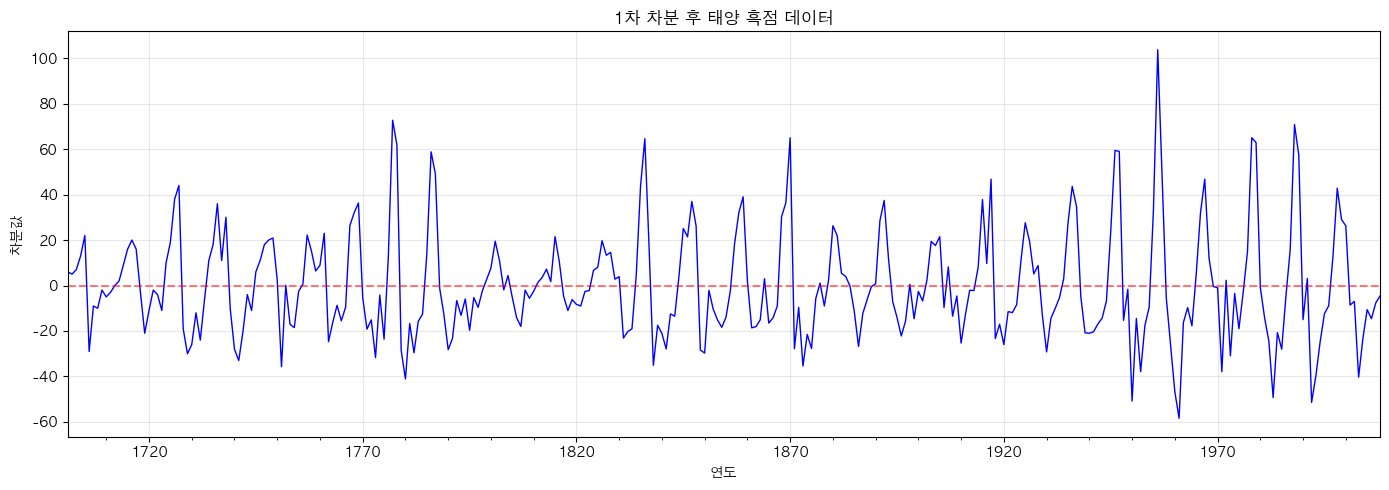

In [25]:
# 1차 차분 적용
# 힌트: 차분 계산 후 결측치 제거
ts_diff = data['SUNACTIVITY'].diff().dropna()

print(f"원본 데이터 개수: {len(data)}개")
print(f"1차 차분 후 데이터 개수: {len(ts_diff)}개")
print(f"\n1차 차분 기본 통계:")
print(ts_diff.describe())

# 시각화
plt.figure(figsize=(14, 5))
ts_diff.plot(title='1차 차분 후 태양 흑점 데이터', color='blue', linewidth=1)
plt.ylabel('차분값')
plt.xlabel('연도')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.1.1 1차 차분 데이터 정상성 검정

In [26]:
# 1차 차분 데이터에 대한 ADF 검정
print("="*50)
print("1차 차분 데이터 ADF 검정")
print("="*50)
is_stationary_adf_diff = adfuller_test(ts_diff)

print("\n" + "="*50)
print("1차 차분 데이터 KPSS 검정")
print("="*50)
is_stationary_kpss_diff = kpss_test(ts_diff)

1차 차분 데이터 ADF 검정
ADF Statistic: -14.86166
p-value: 0.0000
Lags: 7
Number of Observations: 300
검증결과: 정상(stationary) 시계열 데이터입니다.

1차 차분 데이터 KPSS 검정
KPSS Statistic: 0.02119
p-value: 0.1000
Lags: 0
검증결과: 정상(stationary) 시계열 데이터입니다.


/var/folders/ft/29lgxt556sxbnx3pxr3y53r40000gn/T/ipykernel_49425/1060615787.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stats, p_value, nlags, critical_values = kpss(series, **kw)


### 6.1.2 해석

**ADF/KPSS 검정 결과:**
- 1차 차분 후 ADF 검정은 정상성을 확인 (p-value < 0.05)
- KPSS 검정도 정상성을 확인 (p-value > 0.05)

**결론:** 1차 차분만으로도 통계적 검정상 정상성이 확보되었습니다. 하지만 **11년 주기의 계절성**이 완전히 제거되었는지 확인하기 위해 **계절 차분을 추가로 적용**하겠습니다.

## 6.2 계절 차분 (Seasonal Differencing)

계절 차분은 계절 주기만큼 떨어진 시점과의 차이를 계산합니다.

태양 흑점 데이터는 11년 주기를 가지므로 **lag=11**로 계절 차분을 적용합니다.

**1차 차분 + 계절 차분:**

$$\nabla \nabla_{11} Y_t = (Y_t - Y_{t-1}) - (Y_{t-11} - Y_{t-12})$$

- 현재 값 - n개 전 값 (n = 계절 주기)
- diff(n): n 간격으로 차분
- 1차 차분 + 계절 차분으로 추세와 계절성 동시 제거

원본 데이터 개수: 309개
1차 차분 후 데이터 개수: 308개
1차+계절 차분 후 데이터 개수: 297개

1차+계절 차분 기본 통계:
count    297.000000
mean      -0.045791
std       23.542665
min      -77.900000
25%      -10.900000
50%       -0.100000
75%       12.500000
max       82.400000
Name: SUNACTIVITY, dtype: float64


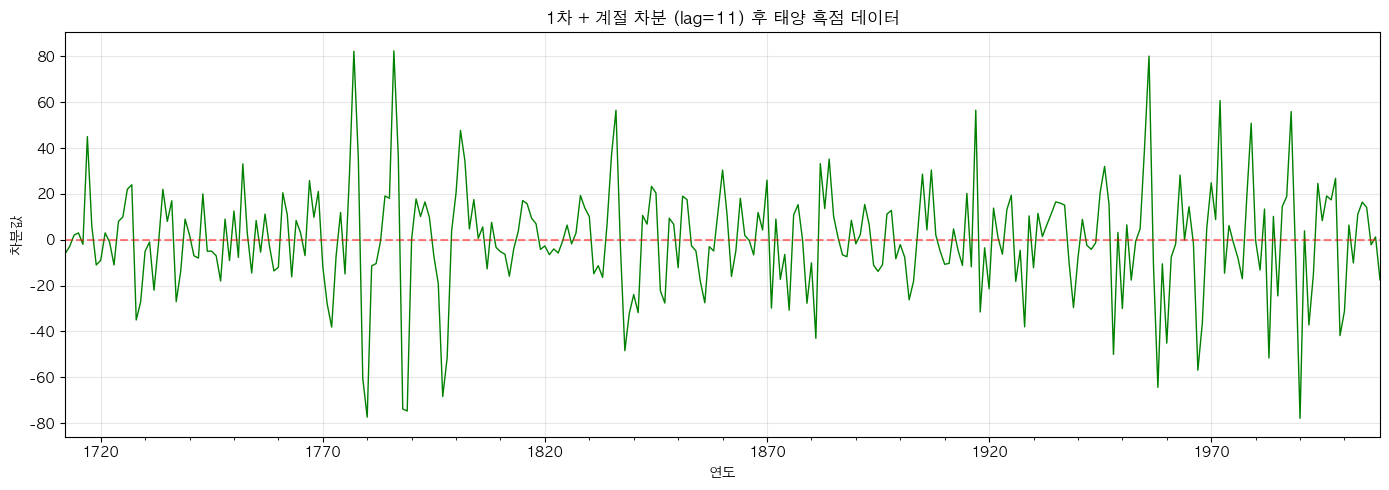

In [27]:
# 1차 차분 + 계절 차분 (lag=11)
# 힌트: 1차 차분 후, 11 간격 차분, 결측치 제거
ts_diff_seasonal = data['SUNACTIVITY'].diff().diff(11).dropna()

print(f"원본 데이터 개수: {len(data)}개")
print(f"1차 차분 후 데이터 개수: {len(ts_diff)}개")
print(f"1차+계절 차분 후 데이터 개수: {len(ts_diff_seasonal)}개")
print(f"\n1차+계절 차분 기본 통계:")
print(ts_diff_seasonal.describe())

# 시각화
plt.figure(figsize=(14, 5))
ts_diff_seasonal.plot(title='1차 + 계절 차분 (lag=11) 후 태양 흑점 데이터', color='green', linewidth=1)
plt.ylabel('차분값')
plt.xlabel('연도')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 6.2.1 계절 차분 데이터 정상성 검정

In [28]:
# 1차+계절 차분 데이터에 대한 ADF 검정
print("="*50)
print("1차+계절 차분 데이터 ADF 검정")
print("="*50)
is_stationary_adf_seasonal = adfuller_test(ts_diff_seasonal)

print("\n" + "="*50)
print("1차+계절 차분 데이터 KPSS 검정")
print("="*50)
is_stationary_kpss_seasonal = kpss_test(ts_diff_seasonal)

1차+계절 차분 데이터 ADF 검정
ADF Statistic: -7.04532
p-value: 0.0000
Lags: 13
Number of Observations: 283
검증결과: 정상(stationary) 시계열 데이터입니다.

1차+계절 차분 데이터 KPSS 검정
KPSS Statistic: 0.02915
p-value: 0.1000
Lags: 14
검증결과: 정상(stationary) 시계열 데이터입니다.


/var/folders/ft/29lgxt556sxbnx3pxr3y53r40000gn/T/ipykernel_49425/1060615787.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stats, p_value, nlags, critical_values = kpss(series, **kw)


### 6.2.2 해석 및 결론

**ADF/KPSS 검정 결과:**
- ADF 검정: 정상성 확인 (p-value < 0.05)
- KPSS 검정: 정상성 확인 (p-value > 0.05)

**결론:** **1차 차분 + 계절 차분(lag=11)을 통해 추세와 계절성이 모두 제거되어 정상성이 확보**되었습니다.

---

## 6.3 SARIMA 모델 파라미터 권장사항

차분 결과를 바탕으로 다음과 같은 **SARIMA(p,d,q)×(P,D,Q,s)** 모델 파라미터를 권장할 수 있습니다:

**비계절 요소:**
- **d = 1**: 1차 차분 적용
- **p, q**: 모델 선택 기준(AIC, BIC)을 통해 결정 (일반적으로 p=1~2, q=1~2)

**계절 요소:**
- **D = 1**: 계절 차분 적용
- **s = 11**: 계절 주기 (11년)
- **P, Q**: 모델 선택 기준을 통해 결정 (일반적으로 P=1, Q=1)

**권장 모델:** SARIMA(1,1,1)×(1,1,1,11) 또는 SARIMA(2,1,2)×(1,1,1,11)

이러한 모델을 사용하여 태양 흑점 수를 예측할 수 있습니다.

---

# Part 7. 결과 저장

## 7.1 데이터 저장

분석한 데이터를 CSV 파일로 저장합니다.

In [29]:
# 원본 데이터 저장
data.to_csv('sunspots_original.csv')
print("✅ 원본 데이터 저장 완료: sunspots_original.csv")

# 1차+계절 차분 데이터 저장
ts_diff_seasonal_df = pd.DataFrame({
    'YEAR': ts_diff_seasonal.index,
    'DIFF_SEASONAL': ts_diff_seasonal.values
})
ts_diff_seasonal_df.to_csv('sunspots_diff_seasonal.csv', index=False)
print("✅ 차분 데이터 저장 완료: sunspots_diff_seasonal.csv")

print(f"\n저장된 파일:")
print(f"1. sunspots_original.csv - 원본 태양 흑점 데이터 ({len(data)}개 관측치)")
print(f"2. sunspots_diff_seasonal.csv - 1차+계절 차분 데이터 ({len(ts_diff_seasonal)}개 관측치)")

✅ 원본 데이터 저장 완료: sunspots_original.csv
✅ 차분 데이터 저장 완료: sunspots_diff_seasonal.csv

저장된 파일:
1. sunspots_original.csv - 원본 태양 흑점 데이터 (309개 관측치)
2. sunspots_diff_seasonal.csv - 1차+계절 차분 데이터 (297개 관측치)


## 7.2 학습 내용 정리

시계열 데이터를 모델링하기 전 데이터를 이해하고 정리하는 데 필수적인 통계적 기법들을 적용해 볼 수 있었습니다!

- 데이터 준비: 날짜 데이터를 datetime 형식으로 변환하고 이를 인덱스로 설정하여 시계열 데이터 구조를 만들었습니다.
- 요소 분해: seasonal_decompose (가법/승법 모형)와 STL을 사용하여 시계열을 추세, 계절성, 잔차로 분리하는 방법을 익혔습니다.
- 결측치 처리: interpolate (Linear) 및 fillna (Backward Fill) 같은 보간 방법을 적용하고, MAE와 RMSE를 사용해 각 방법의 성능을 비교하며 결측치를 처리하는 방법을 배웠습니다.
- 이상치 탐지: IQR과 Z-score와 같은 통계적 방법을 사용하여 시계열 데이터 내의 특이값(이상치)을 탐지하는 기준을 설정하고 적용했습니다.
- 정상성 진단 및 처리:
    - ADF 및 KPSS 검정을 통해 시계열의 정상성 여부를 진단했습니다.
    - 비정상 시계열을 안정화하기 위해 diff() 함수를 사용하여 1차 차분 및 계절 차분을 적용하는 방법을 실습했습니다.